In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from data_loader import load_subject_features
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [1]:
# Extract DL features from the CNN model, 
# calculate the DL features for the data (all RRI segments), and
# update the data files to include those features.

# Define the CNN class (must match the one used for training)
# (copied from deep_learning_features_calculation.ipynb)
class ConvPoolCNN(nn.Module):
    """
    Implementation of the ConvPool-CNN-C architecture.
    Ref.: Springenberg et al. (2015), 'Striving for Simplicity: The All Convolutional Net'.
    Choice of network parameters (filters number, kernel size) for each of the Conv1D layers: (32, 60), (32, 60), (32, 30), (32, 30).
    """

    def __init__(self):
        #super(ConvPoolCNN, self).__init__()
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=60, padding="same")
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=60, padding="same")

        # MaxPooling1D
        self.pool = nn.MaxPool1d(kernel_size=2) # stride = same as kernel size by default

        self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=30, padding="same")
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=30, padding="same")

        # GlobalAveragePooling1D (Deep learning features extractor?)
        # Output layer. Deep learning features (32 dim).
        self.global_avg_pool = nn.AdaptiveAvgPool1d(output_size=1)

        self.fc = nn.Linear(32, 1) # Raw logits. For prediction/inference.

    def forward_features(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.global_avg_pool(x)
        # Output layer. Deep-learning features (32 of them)
        x = x.view(-1, 32)  # shape: [batch_size, 32]
        return x

    def final_fc(self,x):
        x = self.fc(x)
        return x
    
    def forward(self, x):
        # If wanting to get a final output (e.g. regression or classification)
        x = self.forward_features(x)
        x = self.final_fc(x)
        #x = self.fc(x)
        return x

# Define a Pytorch Dataset in order to do the forward pass (get the data in tensor format).
# Include segment_id in order to keep track of what DL features belong to what specific RRI segment.
class RRIDataset(Dataset):
    """
    Expects a DataFrame where each row is one RRI segment with columns:
        segment_id (str)
        RR_interval_sec (list of floats)
        label (0 or 1)
        [optionally database or other info about the segment, which we can ignore here]
    """
    def __init__(self, df_segments):
        self.df = df_segments.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # The time-series of RR intervals, e.g. length=500
        rri_list = row["RR_interval_sec"]
        
        # Convert to torch.FloatTensor.
        # Shape will be [sequence_length]. We unsqueeze(0) so that 
        # final shape is [1, sequence_length] (i.e. one channel).
        rri_tensor = torch.tensor(rri_list, dtype=torch.float).unsqueeze(0)
        
        # Convert label to float. For BCEWithLogitsLoss, label should be float 0.0 or 1.0
        label = torch.tensor(row["label"], dtype=torch.float)

        segment_id = row["segment_id"]  # Get segment ID

        return rri_tensor, label, segment_id

## Load the saved model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvPoolCNN().to(device)

# Select which saved model to use
saved_models_dir = os.path.join("..", "results", "saved_models_CNN_N500")
selected_model = "model_epoch_95.pth"
selected_model_path = os.path.join(saved_models_dir, selected_model)

# "..\\results\\saved_models_CNN_N500\\model_epoch_95.pth"
model.load_state_dict(torch.load(selected_model_path, map_location=device))
model.eval()
print("Loaded model weights from:", selected_model_path)

Loaded model weights from: ..\results\saved_models_CNN_N500\model_epoch_95.pth


In [38]:
# Calculate DL features for each segment and add to existing feature files.

def group_subject_RRI_data_by_segment_id(df_subject):
    """
    Expects columns: 'segment_id', 'RR_interval_sec', 'label' (optionally others).
    Groups by segment_id, returning one row per segment:
       - segment_id
       - RR_interval_sec (list)
       - label (the first value for that segment, i.e. 'first')
    """
    df_segmented = (
        df_subject
        .groupby("segment_id")
        .agg({
            "RR_interval_sec": list,
            "label": "first"
        })
        .reset_index()
    )
    return df_segmented

# Extract DL features (forward pass on each subject in all databases, 
# and for each subject put DL features in the respective dataframe of the subject,
# and save the DL features to csv)

databases = ['BIDMC-CHF', 'CHF-RR', 'NSR', 'NSR-RR', 'FD']

# Directory of the data with segment IDs (not yet grouped by segment ID)
data_dir = os.path.join("..", "data", "cleaned_RRIs", "with_segment_ids_N500")

# Directory of the features of each segment. 
# Previously calculated features should already be saved there. If not, run the relevant cell in statistical_feature_calculations.ipynb.
# The files are to be updated to also include the DL features. 
features_dir = os.path.join("..", "data", "calculated_features", "N500_all_features")

for db in databases:
    print(f"\nProcessing database: {db}")
    db_path_data_load = os.path.join(data_dir, db)
    db_path_features = os.path.join(features_dir, db)
    os.makedirs(db_path_features, exist_ok=True)
    
    if os.path.exists(db_path_data_load):
        for file in os.listdir(db_path_data_load):
            if file.endswith(".csv"): # Go through all subjects in the database
                print(f"  Processing subject file: {file}")
                
                # Load subject RRI data
                rri_data_file_path = os.path.join(db_path_data_load, file)
                df_rris = pd.read_csv(rri_data_file_path) # RRI data of one subject
                # Relevant columns: RR_interval_sec	record	segment_id	label
                # Example values: 0.784	chf01	chf01_001	1

                # Group RR_interval_sec into a list (one row per segment)
                df_rris_segmented = group_subject_RRI_data_by_segment_id(df_rris)
                
                # Drop duplicate 'segment_id's, if any
                df_rris_segmented = df_rris_segmented.drop_duplicates(subset=['segment_id'], keep='first')

                # Load previously calculated features
                # e.g. /data/calculated_features/N500_all_features/BIDMC-CHF/BIDMC-CHF_chf01_features.csv
                # Get the subject id
                subject_id = df_rris['record'].iloc[0] # 'record' is equivalent to 'subject_id'
                features_file = f'{db}_{subject_id}_features.csv'
                features_file_path = os.path.join(db_path_features, features_file)
                df_features = pd.read_csv(features_file_path)

                # Create columns for DL features (initialize with NaN)
                for i in range(32):
                    df_features[f"DL_feature_{i+1}"] = np.nan
                
                # Prepare data for forward pass (Pytorch Dataset and DataLoader)
                rris_dataset = RRIDataset(df_rris_segmented)
                data_loader = DataLoader(rris_dataset, batch_size=32, shuffle=False)

                # Calculate DL features
                with torch.no_grad():
                    for batch_idx, (rri_data, labels, segment_ids) in enumerate(data_loader):
                        # Forward pass
                        rri_data = rri_data.to(device)
                        dl_features = model.forward_features(rri_data).cpu().numpy()

                        for i, segment_id in enumerate(segment_ids):
                            for j in range(32):
                                df_features.loc[df_features['segment_id'] == segment_id, f'DL_feature_{j+1}'] = dl_features[i, j]
                # Save the CSV with the additional DL features columns (overwrite existing features files)
                df_features.to_csv(features_file_path, index=False)


Processing database: BIDMC-CHF


In [45]:
## Evaluate performance of the CNN model

# Assuming the model is already loaded and set to evaluation mode.
# model.eval()

all_preds = []
all_labels = []

# Choose decision threshold for the model (default 0.5)
#decision_threshold = 0.15
thresholds = [0.5, 0.2, 0.15, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.008] # Optionally, run for multiple thresholds
#thresholds = [0.008, 0.006, 0.005]
#thresholds = [0.04]

print(f"Performance results of CNN only model")
print(f"Generated split (folder): {splits_folder}")
print(f"Data subset: {subset}\n")
for decision_threshold in thresholds:
    with torch.no_grad():
        for features, label, segment_id in dataloader:
            # Pass the precomputed DL features through the final layer
            outputs = model.final_fc(features.to(device)) # Raw logits
            probabilities = torch.sigmoid(outputs) # Convert logits to probabilities
            preds = (probabilities > decision_threshold).int() # Convert outputs to binary predictions
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
    
    # Calculate performance metrics (accuracy, sensitivity, specificity)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    accuracy = accuracy_score(all_labels, all_preds)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    print(f"decision_threshold: {decision_threshold}")
    print("Accuracy:", accuracy)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    print()

Performance results of CNN only model
Generated split (folder): generated_splits_2
Data subset: db2

decision_threshold: 0.5
Accuracy: 0.8021240916713248
Sensitivity: 0.7607520564042303
Specificity: 0.8234155781325593

decision_threshold: 0.2
Accuracy: 0.7863531102770902
Sensitivity: 0.7811985898942421
Specificity: 0.7890058055152395

decision_threshold: 0.15
Accuracy: 0.7774494929330032
Sensitivity: 0.7924794359576969
Specificity: 0.7697145621673923

decision_threshold: 0.1
Accuracy: 0.7685259123213287
Sensitivity: 0.8018213866039953
Specificity: 0.7513909046927915

decision_threshold: 0.09
Accuracy: 0.762293380180468
Sensitivity: 0.8082726204465335
Specificity: 0.7386308659893566

decision_threshold: 0.08
Accuracy: 0.7571934307540792
Sensitivity: 0.8133960047003526
Specificity: 0.7282696339300113

decision_threshold: 0.07
Accuracy: 0.7524326667503223
Sensitivity: 0.8177606177606178
Specificity: 0.7188126339069735

decision_threshold: 0.06
Accuracy: 0.747903856903298
Sensitivity: 0.82

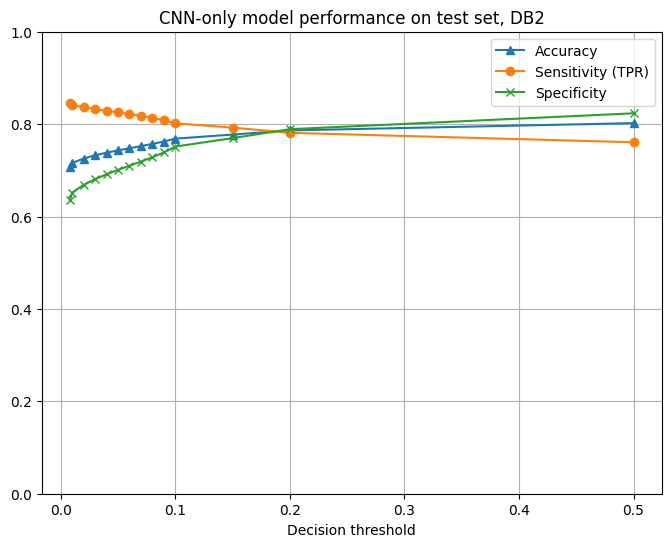

In [12]:
# Plot performance as a function of the decision threshold value

# Data (thresholds in ascending order)
decision_thresholds_all_dbs = [0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.5]
accuracies_all_DBs = [
    0.7659151570219774,  # threshold 0.04
    0.7773865636890227,  # threshold 0.05
    0.7868703503890057,  # threshold 0.06
    0.7934011017093532,  # threshold 0.07
    0.7991935941847919,  # threshold 0.08
    0.8041342495314896,  # threshold 0.09
    0.8081662786075302,  # threshold 0.1
    0.8216820943835539,  # threshold 0.15
    0.8298597308194673,  # threshold 0.2
    0.8535975921403828   # threshold 0.5
]
sensitivities_all_DBs = [
    0.9094302872910242,  # threshold 0.04
    0.90439863658497,    # threshold 0.05
    0.9001785424444084,  # threshold 0.06
    0.8956338256776497,  # threshold 0.07
    0.8919006654763837,  # threshold 0.08
    0.8883298165882162,  # threshold 0.09
    0.8857328355786398,  # threshold 0.1
    0.8738841097224477,  # threshold 0.15
    0.8636584969972407,  # threshold 0.2
    0.8307093004382405   # threshold 0.5
]
specificities_all_DBs = [
    0.6886792452830188,  # threshold 0.04
    0.7090321453529,     # threshold 0.05
    0.7258909853249476,  # threshold 0.06
    0.738382250174703,   # threshold 0.07
    0.7493011879804332,  # threshold 0.08
    0.75882250174703,    # threshold 0.09
    0.7664220824598184,  # threshold 0.1
    0.7935883997204752,  # threshold 0.15
    0.8116701607267645,  # threshold 0.2
    0.8659154437456325   # threshold 0.5
]


decision_thresholds_db1 = [
    0.006, 0.008, 0.01, 0.02, 0.03,
    0.04, 0.05, 0.06, 0.07, 0.08,
    0.09, 0.1, 0.15, 0.2, 0.5
]

accuracies_db1 = [
    0.8064294140778608,  # thr=0.006
    0.8198977585528903,  # thr=0.008
    0.8727225062262419,  # thr=0.01
    0.8903853716083366,  # thr=0.02
    0.8995281163979552,  # thr=0.03
    0.921569012976799,   # thr=0.04
    0.9229038318696203,  # thr=0.05
    0.9240808100668502,  # thr=0.06
    0.9250323015560924,  # thr=0.07
    0.9257766417616988,  # thr=0.08
    0.9264254817145104,  # thr=0.09
    0.9273004325599685,  # thr=0.1
    0.9285620658015468,  # thr=0.15
    0.9291191506095163,  # thr=0.2
    0.929610696028313    # thr=0.5
]

sensitivities_db1 = [
    0.9839622641509433,  # thr=0.006
    0.9820754716981132,  # thr=0.008
    0.964622641509434,   # thr=0.01
    0.9589622641509434,  # thr=0.02
    0.9537735849056603,  # thr=0.03
    0.9204245283018868,  # thr=0.04
    0.9175576519916142,  # thr=0.05
    0.9147995283018868,  # thr=0.06
    0.9119946091644204,  # thr=0.07
    0.9090408805031447,  # thr=0.08
    0.9054716981132076,  # thr=0.09
    0.9012971698113208,  # thr=0.1
    0.895125786163522,   # thr=0.15
    0.8882075471698113,  # thr=0.2
    0.8759433962264151   # thr=0.5
]

specificities_db1 = [
    0.6795347269049224,  # thr=0.006
    0.7039784221173297,  # thr=0.008
    0.8070352888289504,  # thr=0.01
    0.8413688469318948,  # thr=0.02
    0.8607552258934592,  # thr=0.03
    0.9223870532703978,  # thr=0.04
    0.9267251067655653,  # thr=0.05
    0.9307147673634525,  # thr=0.06
    0.9343512185723919,  # thr=0.07
    0.9377388177118453,  # thr=0.08
    0.9414025623735671,  # thr=0.09
    0.9458867161159811,  # thr=0.1
    0.9524612272420768,  # thr=0.15
    0.9583614295347269,  # thr=0.2
    0.9679703304113284   # thr=0.5
]


decision_thresholds_db2 = [
    0.008, 0.01, 0.02, 0.03, 0.04,
    0.05, 0.06, 0.07, 0.08, 0.09,
    0.1, 0.15, 0.2, 0.5
]

accuracies_db2 = [
    0.7068936014875487,  # thr=0.008
    0.7160424818334264,  # thr=0.01
    0.7255383427826133,  # thr=0.02
    0.7324704362155452,  # thr=0.03
    0.738137826399425,   # thr=0.04
    0.7431747806258706,  # thr=0.05
    0.747903856903298,   # thr=0.06
    0.7524326667503223,  # thr=0.07
    0.7571934307540792,  # thr=0.08
    0.762293380180468,   # thr=0.09
    0.7685259123213287,  # thr=0.1
    0.7774494929330032,  # thr=0.15
    0.7863531102770902,  # thr=0.2
    0.8021240916713248   # thr=0.5
]

sensitivities_db2 = [
    0.8456773543730065,  # thr=0.008
    0.841073849769502,   # thr=0.01
    0.8364081472777125,  # thr=0.02
    0.8325606238649716,  # thr=0.03
    0.8288366627497062,  # thr=0.04
    0.8253557905731819,  # thr=0.05
    0.8217097532314923,  # thr=0.06
    0.8177606177606178,  # thr=0.07
    0.8133960047003526,  # thr=0.08
    0.8082726204465335,  # thr=0.09
    0.8018213866039953,  # thr=0.1
    0.7924794359576969,  # thr=0.15
    0.7811985898942421,  # thr=0.2
    0.7607520564042303   # thr=0.5
]

specificities_db2 = [
    0.6354706614140576,  # thr=0.008
    0.6516969967623089,  # thr=0.01
    0.6684808901790034,  # thr=0.02
    0.6809605488850772,  # thr=0.03
    0.6914610546686019,  # thr=0.04
    0.7008815782400688,  # thr=0.05
    0.709920778906628,   # thr=0.06
    0.7188126339069735,  # thr=0.07
    0.7282696339300113,  # thr=0.08
    0.7386308659893566,  # thr=0.09
    0.7513909046927915,  # thr=0.1
    0.7697145621673923,  # thr=0.15
    0.7890058055152395,  # thr=0.2
    0.8234155781325593   # thr=0.5
]

#chosen_subset = "all_dbs"
#chosen_subset = "db1"
chosen_subset = "db2"

# What to put in the title of the plot (indicate what data subset is used)
if chosen_subset == "all_dbs":
    dbs_title = "all DBs"
    decision_thresholds = decision_thresholds_all_dbs
    accuracies = accuracies_all_DBs
    sensitivities = sensitivities_all_DBs
    specificities = specificities_all_DBs

elif chosen_subset == "db1":
    dbs_title = "DB1"
    decision_thresholds = decision_thresholds_db1
    accuracies = accuracies_db1
    sensitivities = sensitivities_db1
    specificities = specificities_db1
    
elif chosen_subset == "db2":
    dbs_title = "DB2"
    decision_thresholds = decision_thresholds_db2
    accuracies = accuracies_db2
    sensitivities = sensitivities_db2
    specificities = specificities_db2

plt.figure(figsize=(8, 6))
plt.plot(decision_thresholds, accuracies, marker='^', label='Accuracy')
plt.plot(decision_thresholds, sensitivities, marker='o', label='Sensitivity (TPR)')
plt.plot(decision_thresholds, specificities, marker='x', label='Specificity')

plt.xlabel('Decision threshold')
plt.title(f'CNN-only model performance on test set, {dbs_title}')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()